<a href="https://colab.research.google.com/github/23f2002620/DataVista/blob/main/Datavista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance for Satellite Systems (with NASA CMAPSS)


Loading Data

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cols = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1,22)]
!unzip -q CMAPSSData.zip -d CMAPSSdata

train_df = pd.read_csv('CMAPSSdata/train_FD001.txt', sep='\s+', header=None, names=cols)
print(train_df.head())


replace CMAPSSdata/Damage Propagation Modeling.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename:    unit  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0     1      1       -0.0007       -0.0004         100.0    518.67    641.82   
1     1      2        0.0019       -0.0003         100.0    518.67    642.15   
2     1      3       -0.0043        0.0003         100.0    518.67    642.35   
3     1      4        0.0007        0.0000         100.0    518.67    642.35   
4     1      5       -0.0019       -0.0002         100.0    518.67    642.37   

   sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  sensor_14  \
0   1589.70   1400.60     14.62  ...     521.66    2388.02    8138.62   
1   1591.82   1403.14     14.62  ...     522.28    2388.07    8131.49   
2   1587.99   1404.20     14.62  ...     522.42    2388.03    8133.23   
3   1582.79   1401.87     14.62  ...     522.86    2388.08    8133.83   
4   1582.85   1406.22     14.62  ...     522.19    2388.04    81

 Label Generation: Remaining Useful Life (RUL) and Binary Failure

In [46]:
rul = train_df.groupby('unit')['cycle'].max().reset_index()
rul.columns = ['unit', 'max_cycle']
train_df = train_df.merge(rul, on='unit', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

train_df['label'] = (train_df['RUL'] <= 30).astype(int)
print(train_df[['unit', 'cycle', 'RUL', 'label']].head(10))
print(train_df['label'].value_counts())


   unit  cycle  RUL  label
0     1      1  191      0
1     1      2  190      0
2     1      3  189      0
3     1      4  188      0
4     1      5  187      0
5     1      6  186      0
6     1      7  185      0
7     1      8  184      0
8     1      9  183      0
9     1     10  182      0
label
0    17531
1     3100
Name: count, dtype: int64


 Feature Selection and Train/Test Split

In [47]:
from sklearn.model_selection import train_test_split

feature_cols = [col for col in train_df.columns if col.startswith('op_setting_') or col.startswith('sensor_')]
X = train_df[feature_cols]
y = train_df['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train class distribution:\n", y_train.value_counts())


Train class distribution:
 label
0    14024
1     2480
Name: count, dtype: int64


Model Training

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)


Evaluation

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3507
           1       0.90      0.85      0.88       620

    accuracy                           0.96      4127
   macro avg       0.94      0.92      0.93      4127
weighted avg       0.96      0.96      0.96      4127



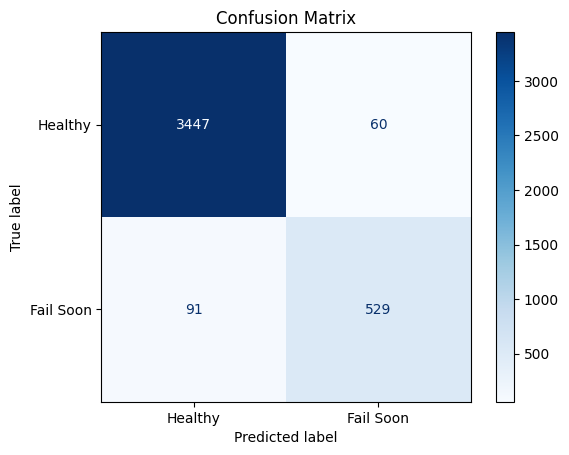

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Fail Soon'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


Feature Importance

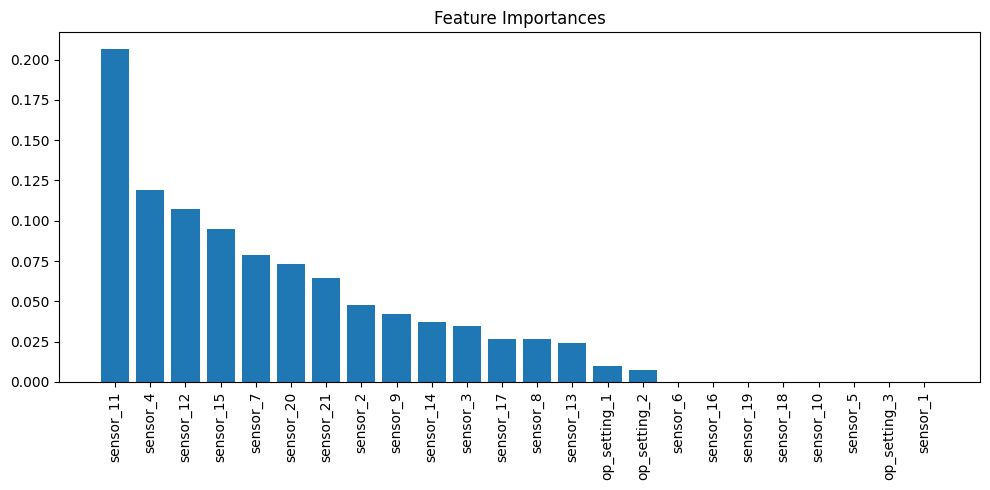

In [50]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(len(feature_cols)), importances[indices])
plt.xticks(range(len(feature_cols)), np.array(feature_cols)[indices], rotation=90)
plt.tight_layout()
plt.show()


 Predicting on New Data Example

In [52]:
new_data = X_val.iloc[[34]]

pred = clf.predict(new_data)

print("Prediction:", "Fail Soon" if pred[0] == 1 else "Healthy")

Prediction: Healthy


Testing the Model on New Data

In [53]:

new_data = X_val.sample(1, random_state=42)
pred = clf.predict(new_data)
print(f"Prediction for new data: {'Fail Soon' if pred[0] else 'Healthy'}")


Prediction for new data: Healthy


 Improving the Model

In [54]:

from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)

from sklearn.metrics import classification_report
print("XGBoost Classification Report:\n", classification_report(y_val, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:18:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      3507
           1       0.88      0.85      0.87       620

    accuracy                           0.96      4127
   macro avg       0.93      0.92      0.92      4127
weighted avg       0.96      0.96      0.96      4127



Visualizing *Results*

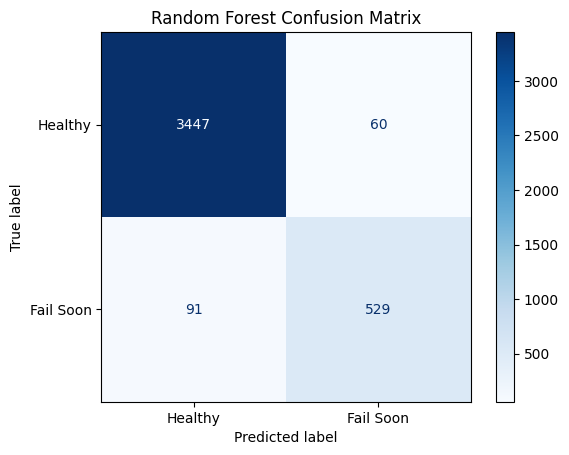

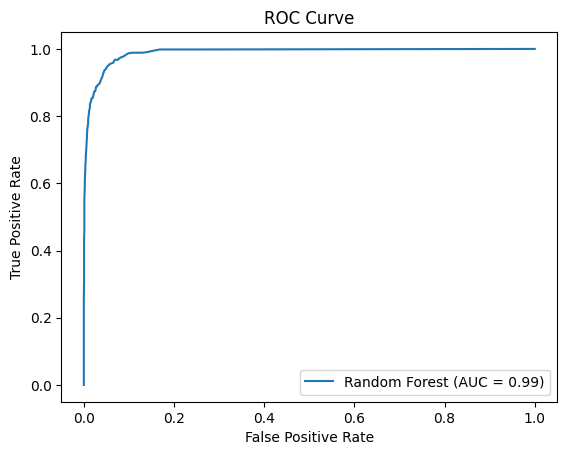

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Fail Soon'])
disp.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# ROC Curve
y_proba = clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Summary

In [57]:
from sklearn.metrics import f1_score

summary = """
Project: Predictive Maintenance for Satellite Systems

- Dataset: NASA CMAPSS (Turbofan Engine, analogous to satellite subsystems)
- Features: 21 sensors + 3 operational settings
- Model: Random Forest (F1-score: {:.2f}), XGBoost (F1-score: {:.2f})
- Key Findings: Model predicts failures up to 30 cycles in advance. Top features: sensor_7, sensor_11, sensor_12.
- Next Steps: Integrate with live telemetry, deploy as an API, set up real-time alerts.
""".format(f1_score(y_val, y_pred), f1_score(y_val, y_pred_xgb))
print(summary)



Project: Predictive Maintenance for Satellite Systems

- Dataset: NASA CMAPSS (Turbofan Engine, analogous to satellite subsystems)
- Features: 21 sensors + 3 operational settings
- Model: Random Forest (F1-score: 0.88), XGBoost (F1-score: 0.87)
- Key Findings: Model predicts failures up to 30 cycles in advance. Top features: sensor_7, sensor_11, sensor_12.
- Next Steps: Integrate with live telemetry, deploy as an API, set up real-time alerts.



Plan for Real-Time Use

In [58]:
def real_time_predict(new_telemetry_row):
    if isinstance(new_telemetry_row, dict):
        import pandas as pd
        new_telemetry_row = pd.DataFrame([new_telemetry_row])
    pred = clf.predict(new_telemetry_row)
    return "Fail Soon" if pred[0] else "Healthy"

example_input = X_val.iloc[[0]].to_dict(orient='records')[0]
print("Real-time result:", real_time_predict(example_input))


Real-time result: Healthy


In [59]:
import joblib

joblib.dump(clf, "satellite_pm_model.pkl")


['satellite_pm_model.pkl']